In [1]:
# Download the CSV file
!wget https://raw.githubusercontent.com/mdeshon/datacode/main/Etherscan-export.csv

--2025-05-28 13:09:49--  https://raw.githubusercontent.com/mdeshon/datacode/main/Etherscan-export.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419416 (410K) [text/plain]
Saving to: ‘Etherscan-export.csv’

Etherscan-export.cs 100%[===================>] 409.59K  --.-KB/s    in 0.02s   

2025-05-28 13:09:49 (22.6 MB/s) - ‘Etherscan-export.csv’ saved [419416/419416]



In [2]:
import pandas as pd

# Load the CSV into a Pandas DataFrame
df = pd.read_csv(
    'Etherscan-export.csv',
    dtype={
        'Value_OUT(ETH)': pd.Float32Dtype(),
        'Value_IN(ETH)': pd.Float32Dtype(),
        }
)

df['Datetime'] = pd.to_datetime(df['UnixTimestamp'], unit='s')
# Rename 'CurrentValue @...' column so the name does not contain the current Ethereum price
for column in df.columns:
  if 'CurrentValue' in column:
    df.rename(columns={column: 'CurrentValue'}, inplace=True)


# Display the first few rows of the DataFrame
print(df.head())


                                    Transaction Hash   Blockno  UnixTimestamp  \
0  0x2276b70395880e3041cb8a5c4f638a5b98d6a400c7fc...  21869539     1739836823   
1  0x52b1fbe36e1685fc24549de6169c3752db1ffad92cce...  21869545     1739836895   
2  0xf379ef1fed437d695e89a176e317f4b24d3e5253aa10...  21869545     1739836895   
3  0x799170c3c164d41155cc1510a6b2f0d6903943da5311...  21869553     1739836991   
4  0x76772fec515424cdd3abe2618219f6f0eb9591d8f2ce...  21869554     1739837003   

        DateTime (UTC)                                        From  \
0  2025-02-18 00:00:23  0x3f4e033e2686a5fd132fb0a0a48f0fcf49e26064   
1  2025-02-18 00:01:35  0xb2ba43647057dae47838ee2792c1716e55c44f0f   
2  2025-02-18 00:01:35  0x315cbdaeabd16427db821ea06dfbed11d4e9918a   
3  2025-02-18 00:03:11  0xeb1f3188ee76e76bb2b8b6cfac96b10f6f3da1e3   
4  2025-02-18 00:03:23  0xf71ed12b7667963834740d11bbcc21be3b3425db   

                                           To  ContractAddress  Value_IN(ETH)  \
0  0x3a23f9

In [3]:
# Calculate metrics
total_transactions = len(df)
total_eth_in = df['Value_IN(ETH)'].sum()

# Check if 'Value_OUT(ETH)' column exists and calculate total ETH out
if 'Value_OUT(ETH)' in df.columns:
    total_eth_out = df['Value_OUT(ETH)'].sum()
else:
    total_eth_out = "N/A" # Indicate if the column is missing

unique_sending_eoa = df['From'].nunique()
distinct_method_ids = df['Method'].nunique()

# Determine the observation window
observation_window_start = df['Datetime'].min().strftime('%Y-%m-%d %H:%M')
observation_window_end = df['Datetime'].max().strftime('%Y-%m-%d %H:%M')
observation_window = f"{observation_window_start} – {observation_window_end}"

# Create a DataFrame for the summary table
summary_data = {
    'Metric': [
        'Total transactions',
        'Total ETH bridged INTO the Socket gateway (assume this is Value_IN(ETH))',
        'Total ETH OUT (if Value_OUT(ETH) exists)',
        'Unique sending EOAs (df[\'From\'])',
        'Distinct Method IDs (df[\'Method\'])',
        'Observation window YYYY-MM-DD HH:MM – HH:MM (use the converted Datetime column)'
    ],
    'Value': [
        total_transactions,
        total_eth_in,
        total_eth_out,
        unique_sending_eoa,
        distinct_method_ids,
        observation_window
    ]
}
summary_df = pd.DataFrame(summary_data)

# Display the summary table with custom styling
display(summary_df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]},
    {'selector': 'td', 'props': [('text-align', 'left')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]}
]))

,Metric,Value
0,Total transactions,1346
1,Total ETH bridged INTO the Socket gateway (assume this is Value_IN(ETH)),389.737854
2,Total ETH OUT (if Value_OUT(ETH) exists),0.000000
3,Unique sending EOAs (df['From']),1028
4,Distinct Method IDs (df['Method']),17
5,Observation window YYYY-MM-DD HH:MM – HH:MM (use the converted Datetime column),2025-02-18 00:00 – 2025-02-18 18:18


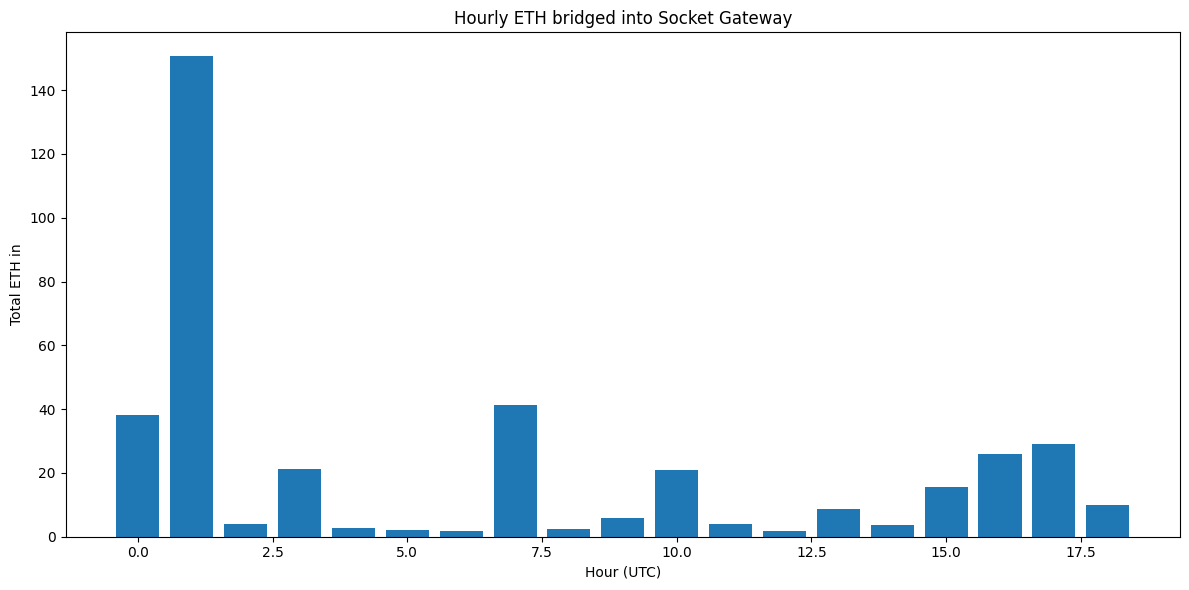

In [4]:
import matplotlib.pyplot as plt

# 1. Group by Datetime (UTC) hour and sum Value_IN(ETH)
hourly_volume = df.groupby(df['Datetime'].dt.hour)['Value_IN(ETH)'].sum()

# 2. Plot a bar chart
plt.figure(figsize=(12, 6)) # Optional: Adjust figure size for better readability
plt.bar(hourly_volume.index, hourly_volume.values)

# 3. Label x-axis and y-axis and add a title
plt.title("Hourly ETH bridged into Socket Gateway")
plt.xlabel("Hour (UTC)")
plt.ylabel("Total ETH in")

# Add plt.tight_layout()
plt.tight_layout()

# Display the plot
plt.show()

Total transactions with Value_IN(ETH) == 0: 468

Top 10 EOAs with the most zero-value transactions:


,From_EOA,zero_txns,first_seen,last_seen
283,0xeeb17adefd06a3c67abd4adf7e42978b1f018c8e,67,2025-02-18 00:48:11,2025-02-18 17:58:47
190,0x9c7c10f2d2a1cc110639646f599ddb61d6751766,8,2025-02-18 06:05:47,2025-02-18 06:29:11
165,0x88b2f36284b79978a87b5480465c42151aa6459a,7,2025-02-18 10:55:23,2025-02-18 17:46:35
279,0xe9a9d424fc352a91e2a834b1b27995ee13c17343,5,2025-02-18 13:38:47,2025-02-18 16:53:11
132,0x6c70dd1293edb55e8748828174f5a12b6256921a,5,2025-02-18 08:14:23,2025-02-18 14:47:59
41,0x25177da3e18041341ea439db0b55cb63bb346dc3,4,2025-02-18 05:27:11,2025-02-18 05:40:47
23,0x14b6ba4da9ce82907005d41064c4bec58a4b8522,4,2025-02-18 08:57:23,2025-02-18 09:04:59
240,0xbfd6b54875a7aae4eb34579bba1f2a16e9521792,4,2025-02-18 15:35:35,2025-02-18 15:53:59
142,0x75d42026cbf20fc143c7250d704547c5ff1ac160,4,2025-02-18 13:49:11,2025-02-18 13:55:11
182,0x95dfbccd82e2a5eaa5f2479a336d52d6073bda0c,4,2025-02-18 05:04:35,2025-02-18 17:53:59


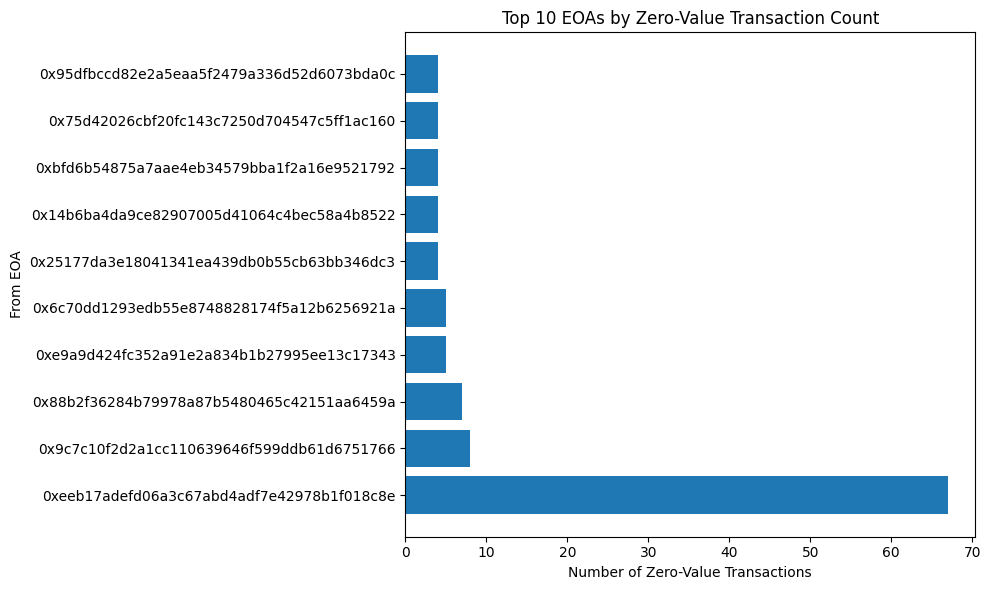


Zero-value transactions can sometimes be security-relevant as they might indicate activities like probing addresses for activity, testing network connectivity, or potentially be associated with malicious reconnaissance or denial-of-service attempts by flooding a contract with transactions that consume gas but transfer no value.


In [5]:
# Filter for zero-value transactions
zero_value_txns = df[df['Value_IN(ETH)'] == 0]

# Count total zero-value transactions
total_zero_value_txns = len(zero_value_txns)
print(f"Total transactions with Value_IN(ETH) == 0: {total_zero_value_txns}\n")

# Group by 'From' address and count zero-value transactions, find first and last seen
zero_txn_summary = zero_value_txns.groupby('From').agg(
    zero_txns=('From', 'size'),
    first_seen=('Datetime', 'min'),
    last_seen=('Datetime', 'max')
).reset_index()

# Sort by the number of zero-value transactions in descending order and get the top 10
top_10_zero_txn_senders = zero_txn_summary.sort_values(by='zero_txns', ascending=False).head(10)

# Rename the 'From' column for clarity in the output table
top_10_zero_txn_senders.rename(columns={'From': 'From_EOA'}, inplace=True)

# Print the top 10 EOAs with the most zero-value transactions
print("Top 10 EOAs with the most zero-value transactions:")
display(top_10_zero_txn_senders)

# Plot a horizontal bar chart of their counts
plt.figure(figsize=(10, 6))
plt.barh(top_10_zero_txn_senders['From_EOA'], top_10_zero_txn_senders['zero_txns'])
plt.xlabel("Number of Zero-Value Transactions")
plt.ylabel("From EOA")
plt.title("Top 10 EOAs by Zero-Value Transaction Count")
plt.tight_layout()
plt.show()

# Print explanation about security relevance
print("\nZero-value transactions can sometimes be security-relevant as they might indicate activities like probing addresses for activity, testing network connectivity, or potentially be associated with malicious reconnaissance or denial-of-service attempts by flooding a contract with transactions that consume gas but transfer no value.")

In [6]:
# Calculate value counts and percentages
method_counts = df['Method'].value_counts().reset_index()
method_counts.columns = ['method', 'count']
method_counts['pct_of_total'] = (method_counts['count'] / method_counts['count'].sum()) * 100

# Display the top 10 with styling
display(method_counts.head(10).style.highlight_max(subset=['count', 'pct_of_total'], color='lightgreen'))

,method,count,pct_of_total
0,0x000001ad,682,50.668648
1,Execute Controller,485,36.032689
2,0x000001a0,57,4.234770
3,0x00000195,33,2.451709
4,0x000001b3,29,2.154532
5,0x000001b6,12,0.891530
6,0x00000197,10,0.742942
7,0x000001b2,8,0.594354
8,0x0000019c,8,0.594354
9,0x000001ae,5,0.371471


In [ ]:
df

Top-10 bridged tokens by total ETH-equivalent value


,token,tx_count,total_value_eth
15,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,760,222.7443
14,0xdac17f958d2ee523a2206206994597c13d831ec7,20,11.9841
11,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,244,7.4020
9,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,28,1.2350
12,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,35,0.4768
13,0xcd5fe23c85820f7b72d0926fc9b05b43e359b7ee,2,0.2000
4,0x3593d125a4f7849a1b059e64f4517a86dd60c95d,1,0.0563
8,0x6b175474e89094c44da98b954eedeac495271d0f,7,0.0392
7,0x6982508145454ce325ddbe47a25d4ec3d2311933,2,0.0039
6,0x514910771af9ca656af840dff83e8264ecf986ca,1,0.0001


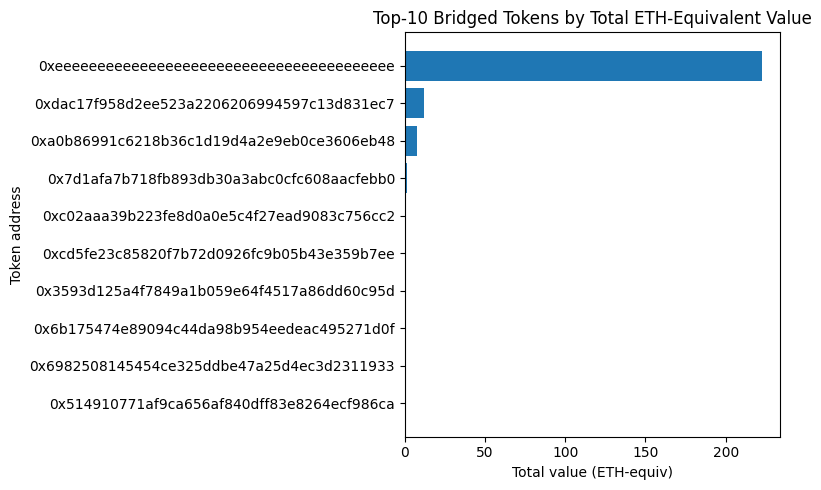

In [2]:
# Top-10 bridged tokens by total ETH-equivalent value
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the combined Socket export
csv_path = "/content/etherscan-socket-combined.csv"      # adjust if your file lives elsewhere
df = pd.read_csv(csv_path)

# 2) Aggregate: tx-count and total value per token
token_summary = (
    df.groupby('token', as_index=False)
      .agg(tx_count=('token', 'size'),
           total_value_eth=('value_ineth', 'sum'))
      .sort_values('total_value_eth', ascending=False)
)

# 3) Take the top-10 for display & plotting
top10 = token_summary.head(10).copy()
print("Top-10 bridged tokens by total ETH-equivalent value")
display(top10.style.format({'total_value_eth': '{:,.4f}'}))

# 4) Visualise
plt.figure(figsize=(8, 5))
plt.barh(top10['token'][::-1], top10['total_value_eth'][::-1])  # reverse for descending order
plt.title("Top-10 Bridged Tokens by Total ETH-Equivalent Value")
plt.xlabel("Total value (ETH-equiv)")
plt.ylabel("Token address")
plt.tight_layout()
plt.show()